In [1]:
import chess.pgn
import pandas as pd
import chess
import numpy as np
from scipy import linalg

In [2]:
ls -shr

total 89M
16K README.md                              88K chess-and-eigenvectors.ipynb
89M lichess_db_standard_rated_2013-01.pgn


In [3]:
board = chess.Board()

In [4]:
pgn = open('lichess_db_standard_rated_2013-01.pgn',encoding="utf-8")

In [5]:
#creates a list with one entry for each space on the board
spaces = []
for i in range(1,9):
    for j in range (1,9):
        spaces.append(chr(j+96)+str(i))

In [6]:
#create a matrix to tally weights for every pair of opposing pieces
pieces_list = [space for space in spaces if any(map(space.__contains__, ['1','2','7','8']))]
weights = pd.DataFrame(0,index=pieces_list, columns=pieces_list)

In [7]:
#create a state dictionary of each square and the initial square of each piece
#Those 'None' entries are the empty squares in the middle of the board, before the first move
#Each piece is on it's own square to begin
state_dict = {space:(space  if any(map(space.__contains__, ['1','2','7','8'])) else None) for space  in spaces}
#state_dict

In [8]:
game_counter = 0
total_move_counter = 0
game = chess.pgn.read_game(pgn)

while game is not None:
    counter = 0
    state_dict = {space:(space  if any(map(space.__contains__, ['1','2','7','8'])) else None) for space  in spaces}

    #print(game)
    #do stuff here



    #for each line in the file
    for move in game.mainline_moves():
        counter += 1
        if board.is_pseudo_legal(move):


            if board.is_capture(move):
                capturing_piece = state_dict[chess.square_name(move.from_square)]
                captured_piece = state_dict[chess.square_name(move.to_square)]
                #print('capturing piece',capturing_piece)
                #print('captured piece',captured_piece)

                if board.is_en_passant(move):
                    #do en passant stuff here
                    #print("en passant")

                       
                    #print ('to square',chess.square_name(move.to_square))
                    #print ('to square file',chess.square_file(move.to_square))
                    #print ('to square rank',chess.square_rank(move.to_square))
                    file = chess.square_file(move.to_square)
                    rank = chess.square_rank(move.to_square)

                    if board.turn:
                        #white's turn, take piece behind square where pawn ends up, decrease rank by 1
                        rank = rank-1
                        #print('white')
                    else:
                        #blacks's turn, take piece behind square where pawn ends up
                        rank = rank+1
                        #print("black")
                    take_square = chess.square_name(chess.square(file, rank)) 
                    #print('take square',take_square)
                    
                    #increment an entry in the weights matrix when one piece takes another
                    weights.loc[state_dict[chess.square_name(move.from_square)],state_dict[take_square]] += 1

                    #update the take square to be empty
                    state_dict[take_square] = None

                    #update the piece on the target square
                    state_dict[chess.square_name(move.to_square)] = state_dict[chess.square_name(move.from_square)]

                    #update the source square to be empty
                    state_dict[chess.square_name(move.from_square)] = None

                elif capturing_piece is not None:
                    if captured_piece is not None:

                        #record the kill in a matrix of all kills
                        #print(counter,chess.square_name(move.from_square), "takes on",chess.square_name(move.to_square))
                        #print(counter,state_dict[chess.square_name(move.from_square)], "takes",state_dict[chess.square_name(move.to_square)])

                        #what piece is there now?
                     

                        #increment an entry in the weights matrix when one piece takes another
                        weights.loc[state_dict[chess.square_name(move.from_square)],state_dict[chess.square_name(move.to_square)]] += 1

                        #update the piece on the target square
                        state_dict[chess.square_name(move.to_square)] = state_dict[chess.square_name(move.from_square)]

                        #update the source square to be empty
                        state_dict[chess.square_name(move.from_square)] = None

                        #board.push(move)  # Make the move


                        #if df.loc[i+1,'move_no'] == 1:
                        #    state_dict = {space:(space  if any(map(space.__contains__, ['1','2','7','8'])) else None) for space  in spaces}

            else:


                #add castling special cases to record both moves
                if board.is_kingside_castling(move):
                    if board.turn:
                        #print(counter,'... and white castles kingside')
                        #move the appopriate rook
                        state_dict['f1'] = 'h1'
                        #leaving the rook source square empty
                        state_dict['h1'] = 'None'
                        #board.push(move)  # Make the move



                    elif not board.turn:
                        #print(counter,'... and black castles kingside')
                        #move the appopriate rook
                        state_dict['f8'] = 'h8'
                        #leaving the rook source square empty
                        state_dict['h8'] = 'None'
                        #board.push(move)  # Make the move

                elif board.is_queenside_castling(move):
                    if board.turn:
                        #print(counter,'... and white castles queenside')
                        #move the appopriate rook
                        state_dict['d1'] = 'a1'
                        #leaving the rook source square empty
                        state_dict['a1'] = 'None'
                        #board.push(move)  # Make the move

                    elif not board.turn:
                        #print(counter,'... and black castles queenside')
                        #move the appopriate rook
                        state_dict['d8'] = 'a8'
                        #leaving the rook source square empty
                        state_dict['a8'] = 'None'
                        #board.push(move)  # Make the move

                else:
                    #update the piece on the target square
                    state_dict[chess.square_name(move.to_square)] = state_dict[chess.square_name(move.from_square)]

                    #update the source square to be empty
                    state_dict[chess.square_name(move.from_square)] = None


                    #print(counter, chess.square_name(move.from_square),chess.square_name(move.to_square))

        board.push(move)  # Make the move
        #print(state_dict)
            
    if board.is_checkmate():
        checkers_list = [state_dict[chess.square_name(x)] for x in list(board.checkers())]
        if checkers_list[0] is not None:
            piece_giving_check = str(checkers_list[0])

            if board.turn:
                captured_king = 'e1'
            else:
                captured_king = 'e8'
            weights.loc[piece_giving_check,captured_king] += 1

    
    game_counter += 1
    #print('end of game',game_counter)
    
    total_move_counter += counter
    #print('total moves analyzed',total_move_counter)

    
    #print('board outcome',board.outcome())


    #print('is game over?',board.is_game_over())
    board.reset()

    game = chess.pgn.read_game(pgn)




    #print(state_dict)

    

In [9]:
print(game_counter,'games analyzed')
print(total_move_counter,'moves analyzed')

121332 games analyzed
8155187 moves analyzed


In [10]:
weights

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,...,g7,h7,a8,b8,c8,d8,e8,f8,g8,h8
a1,0,49,39,43,0,37,30,76,149,132,...,2676,2990,13085,3782,4559,5091,2224,4378,3256,9964
b1,54,0,28,21,0,24,30,54,57,56,...,1630,1322,4091,5463,6863,4425,334,9428,13587,2842
c1,124,66,0,106,0,58,62,151,113,99,...,3867,3528,2951,8948,0,4251,336,21744,20205,4977
d1,99,42,37,0,0,28,30,88,99,78,...,6963,6669,8170,12835,15998,27358,9398,10879,11252,8226
e1,0,0,0,0,0,0,0,0,0,0,...,467,495,1106,952,1194,2412,0,1603,1276,1146
f1,76,25,42,53,0,0,33,85,69,70,...,1814,2797,4156,18527,21368,3470,367,0,11573,2969
g1,66,32,41,32,0,21,0,85,47,47,...,3184,2340,2283,16197,8303,4319,260,6993,5724,4198
h1,134,52,42,38,0,45,44,0,170,138,...,4257,4317,10206,4000,5173,5632,2277,5319,4792,12802
a2,29,16,13,2,0,14,14,22,0,96,...,115,132,352,1607,1002,594,461,653,332,208
b2,30,16,11,6,0,14,13,33,147,0,...,74,84,465,1441,687,630,365,7444,2401,258


In [ ]:
#This still clearly contains some bug or bugs, not sure where the self-captures could be coming from. Possibly a
#mistake in the state dict when accounting for en passants.
#The number of mistakes is still very low, apparently less than one percent, which doesn't skew results all that much.

In [11]:
#subtracting the identity matrix is necessary, forming an implicit set of homogeneous equations
a = weights - np.identity(32)
#print(a)

In [12]:
b = np.zeros(32)
#print(b)

In [13]:
x = linalg.solve(a, b)
x

array([ 0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,
       -0., -0., -0., -0., -0., -0.])

### Why doesn't it work?
### Because the solver is finding the trivial solution. i.e. just a vector full of zeroes.
### To check that there is actually a non trivial solution, the determinant of A must be non-zero.

In [14]:
np.linalg.det(a)

8.477595324290956e+119

### OK since the determinant is not zero, there must be at least one non-trivial solution. How to find it?
### An homogenous linear equation can be solved by finding the eigenvectors.

In [15]:
eigen_values, eigen_vectors = np.linalg.eig(a)  
eigen_vectors

array([[ 0.17853155+0.j,  0.17658335+0.j, -0.24118579+0.j, ...,
        -0.14873992+0.j, -0.15041371+0.j,  0.17807831+0.j],
       [ 0.19359861+0.j,  0.19387402+0.j, -0.02724016+0.j, ...,
         0.00154408+0.j,  0.00293654+0.j,  0.00238546+0.j],
       [ 0.24129191+0.j,  0.23887936+0.j, -0.18636213+0.j, ...,
        -0.02474659+0.j, -0.02076647+0.j, -0.0254878 +0.j],
       ...,
       [ 0.23949465+0.j, -0.23919418+0.j, -0.17522941+0.j, ...,
        -0.13081652+0.j,  0.11463928+0.j, -0.10311071+0.j],
       [ 0.1973653 +0.j, -0.19732985+0.j,  0.00694406+0.j, ...,
         0.08156574+0.j, -0.07186051+0.j,  0.05298552+0.j],
       [ 0.1840589 +0.j, -0.18149763+0.j, -0.25217697+0.j, ...,
         0.09940041+0.j, -0.10291745+0.j,  0.03924622+0.j]])

In [29]:
values = eigen_vectors[:, np.argmax(eigen_values)] 
values
#Notice that the entries of the eigenvector corresponding to the largest eigenvalue are all real valued,
#So it's OK to throw away the imaginary component

array([0.17853155+0.j, 0.19359861+0.j, 0.24129191+0.j, 0.46179917+0.j,
       0.04258898+0.j, 0.23755919+0.j, 0.20797482+0.j, 0.19388739+0.j,
       0.02918162+0.j, 0.06119117+0.j, 0.06202557+0.j, 0.07382312+0.j,
       0.08058662+0.j, 0.06124037+0.j, 0.05327563+0.j, 0.03080381+0.j,
       0.02702661+0.j, 0.06697645+0.j, 0.06730137+0.j, 0.07665119+0.j,
       0.08378771+0.j, 0.06274823+0.j, 0.05385892+0.j, 0.03280015+0.j,
       0.18258961+0.j, 0.19807649+0.j, 0.22923698+0.j, 0.45053278+0.j,
       0.05744983+0.j, 0.23949465+0.j, 0.1973653 +0.j, 0.1840589 +0.j])

In [30]:
## Let's normalize the values


In [31]:
list = []
for i in values:
    list.append(abs(float(i)))

<ipython-input-31-fd238d3eb4fa>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  list.append(abs(float(i)))


In [32]:
#The fractional inverse of the average of all the pawns
factor = 1 / np.mean(list[8:24])

In [33]:
normed = [i*factor for i in list]
#normed

In [34]:
normalized_list = ["%.2f"%i for i in normed]

In [36]:
#tempo difference
white_sum = sum(normed[0:16])
black_sum = sum(normed[16:32])


print('total value of white pieces is', white_sum)
print('total value of black pieces is', black_sum)
print('total difference in value between white and black pieces is', white_sum-black_sum)
print('This is equal to the point value of the tempo advantage for white')

total value of white pieces is 38.28720188860989
total value of black pieces is 38.2975240361024
total difference in value between white and black pieces is -0.01032214749250926
This is equal to the point value of the tempo advantage for white


['3.16', '3.43', '3.97', '7.81', '1.00', '4.15', '3.42', '3.19']
['0.47', '1.16', '1.17', '1.33', '1.45', '1.09', '0.93', '0.57']
['0.51', '1.06', '1.07', '1.28', '1.40', '1.06', '0.92', '0.53']
['3.09', '3.35', '4.18', '8.00', '0.74', '4.12', '3.60', '3.36']


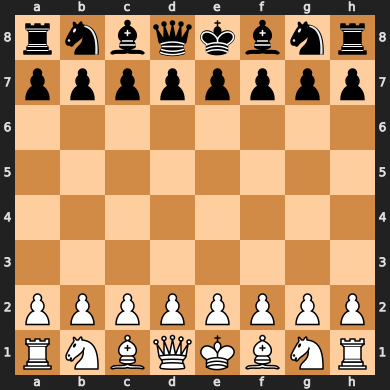

In [35]:
print(normalized_list[24:32])
print(normalized_list[16:24])
print(normalized_list[8:16])
print(normalized_list[0:8])

In [ ]:
if not os.path.isfile('blank-board.png'):
    svg2png(bytestring=chess.svg.board(board),write_to='blank-board.png',scale=2)

In [ ]:
im = cv2.imread('blank-board.png')

In [ ]:
black_major_pieces = ' '.join(normalized_list[24:32])
black_pawns = ' '.join(normalized_list[16:24])
white_pawns = ' '.join(normalized_list[8:16])
white_major_pieces = ' '.join(normalized_list[0:8])

In [ ]:
color = (0, 0, 255)
black = (0, 0, 0)
white = (255, 255, 255)

cv2.putText(img=im, 
            text=black_major_pieces, org=(30, 132), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1.05, 
            color=white,thickness=2)
cv2.putText(img=im, 
            text=black_pawns, org=(30, 210), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1.05, 
            color=white,thickness=2)
cv2.putText(img=im, 
            text=white_pawns, org=(30, 584), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1.05, 
            color=black,thickness=2)
cv2.putText(img=im, 
            text=white_major_pieces, org=(30, 674), 
            fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1.05, 
            color=black,thickness=2)


In [ ]:
fig, ax = plt.subplots(dpi=200)
plt.imshow(im,)

In [ ]:
cv2.imwrite('chess-values.png',im)

In [24]:
#Notice that, for each pair of opposing pawns, the black pawn is stronger in 7 out of 8 pairs
#Why should this be? Possibly because white has the initial tempo for attacking early in the game,
#giving the black pawns many opportunities for capturing pieces defensively, and practically necessitating it.

In [25]:
#find average strength of all the pieces taken by each piece
#eg, rook strength seems low in general, probably because they come out later in the game
#and have fewer opportunities to capture lots of pieces,
#but they probably capture, on average, stronger pieces, in proportion to their own strength 